# Team Brainstorm - Bloomberg Challenge - TAMU Datathon 2022
Jacob Mashburn,
Molly Mckinney,
Moeka Ono,
Erin Mok

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
import json

# PART 1
## Guesses for each article (methodology to follow)

1. An article on recommended travel/tourist destinations.

2. Nice things happening in the pandemic: stimulus checks, Matthew Mcconaughey showing people how to make a mask out of a coffee filter, and people buying coffees for essential workers.

3. An article written during/about the COVID-19 pandemic.

4. The war on terror in the Middle East.

5. Long-term consequences of climate change, maybe with some remarks on what we can do about it now.

## Training dataset importing

In [2]:
cnn_samples0 = pd.read_csv('cnn_samples-54b19b96f3c0775b116bad527df8c7b5.csv')

# Wrangling the data from strings to NP arrays.
cnn_samples1 = np.fromstring((cnn_samples0.values[0,3]).replace('[','').replace(']',''), sep=',').reshape(1,512)

# Rebuilding the DataFrame after this, with headline as index.
for i in np.arange(1,np.shape(cnn_samples0)[0]):
    temp = np.fromstring((cnn_samples0.values[i,3]).replace('[','').replace(']',''), sep=',').reshape(1,512)
    cnn_samples1 = np.vstack([cnn_samples1, temp])
cnn_samples = pd.DataFrame(cnn_samples1, index = cnn_samples0['text'])

#Repeating the process for the challenge data.
gov_samples0 = pd.read_csv('federal_samples-a586d0681e005629453435bea5b173eb.csv')
gov_samples1 = np.fromstring((gov_samples0.values[0,3]).replace('[','').replace(']',''), sep=',').reshape(1,512)
for i in np.arange(1,np.shape(gov_samples0)[0]):
    temp = np.fromstring((gov_samples0.values[i,3]).replace('[','').replace(']',''), sep=',').reshape(1,512)
    gov_samples1 = np.vstack([gov_samples1, temp])
gov_samples = pd.DataFrame(gov_samples1, index = gov_samples0['text'])

#also need to merge the two DataFrames
cnngov_samples = pd.concat([cnn_samples, gov_samples], axis = 'rows')

#Repeating the process for the challenge data.
challenge0 = pd.read_csv('challenge-ddec63cf66ea88f128e3c21e457f393a.csv')
challenge1 = np.fromstring((challenge0.values[0,1]).replace('[','').replace(']',''), sep=',').reshape(1,512)
for i in np.arange(1,np.shape(challenge0)[0]):
    temp = np.fromstring((challenge0.values[i,1]).replace('[','').replace(']',''), sep=',').reshape(1,512)
    challenge1 = np.vstack([challenge1, temp])
challenge = pd.DataFrame(challenge1, index = challenge0['id'])


#Finally, getting the mystery 6th article.
with open('mystery.json') as file:
    mystery0 = json.load(file)['embedding']

mystery = pd.DataFrame(np.array(mystery0).reshape(1,512), index = ['mystery'], columns = np.arange(0,512)) #it's a dict

#also need to merge these two DataFrames
challenge = pd.concat([challenge, mystery], axis = 'rows')

#print(cnngov_samples.head()) #just double-checking
#print(challenge.head())

## Trying K-means (as a rough starting point with no labels whatsoever)

<class 'numpy.ndarray'>
[39 50  4  3  8 83]


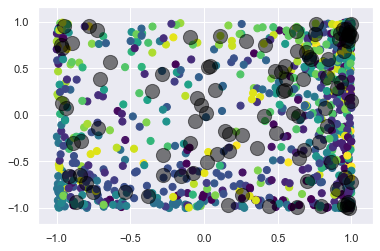

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
kmeans.fit(cnngov_samples)
y_kmeans = kmeans.predict(cnngov_samples) #in addition to coloring, we can use these to make Boolean masks to view contents of each cluster KM predicted for the challenge articles.
print(type(y_kmeans))

plt.scatter(cnngov_samples.values[:, 0], cnngov_samples.values[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

#the moment of truth
challengeKM = kmeans.predict(challenge)
print(challengeKM)

#great, let's mask the original cnngov_sample DataSeries with Boolean arrays generated by y_kmeans
article1KM = y_kmeans == challengeKM[0]
article2KM = y_kmeans == challengeKM[1]
article3KM = y_kmeans == challengeKM[2]
article4KM = y_kmeans == challengeKM[3]
article5KM = y_kmeans == challengeKM[4]
article6KM = y_kmeans == challengeKM[5]

clusterArticle1KM = cnngov_samples[article1KM].index.values.tolist()
clusterArticle2KM = cnngov_samples[article2KM].index.values.tolist()
clusterArticle3KM = cnngov_samples[article3KM].index.values.tolist()
clusterArticle4KM = cnngov_samples[article4KM].index.values.tolist()
clusterArticle5KM = cnngov_samples[article5KM].index.values.tolist()
clusterArticle6KM = cnngov_samples[article6KM].index.values.tolist()

## Trying K-Nearest Neighbor with a TF-IDF Vectorizer as Target Array (to count/weigh important words)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# TF-IDF word frequency counter (for headlines)
vec = TfidfVectorizer()
cnnX = vec.fit_transform(pd.concat([cnn_samples0['text'],gov_samples0['text']]))
Y = pd.DataFrame(cnnX.toarray(), columns=vec.get_feature_names())
Y = Y.drop(columns = stopwords.words('english'), errors = 'ignore') #remove filler words (Stopwords)

top_n = 12 #return the top N words from each source, except the WordCloud Stopwords.
Z = pd.DataFrame({n: Y.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(Y.T)}).T

#print(Z)

knnModel = KNeighborsClassifier(n_neighbors= 10, algorithm = 'auto', p = 2, metric = 'cosine')
knnModel.fit(cnngov_samples, Z)

#Had to comment this out for space
print('Probability estimates for the test data:')
print(knnModel.predict_proba(challenge))

# the moment of truth...
challengeKNN = knnModel.kneighbors(challenge, n_neighbors = 10, return_distance = True)
print('The challenge articles\' 5 nearest neighbors according to the KNN algorithm:')
print(challengeKNN[1])

article1KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,7]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,8]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][0,9])
article2KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,7]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,8]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][1,9])
article3KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,7]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,8]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][2,9])
article4KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,7]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,8]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][3,9])
article5KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,7]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,8]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][4,9])
article6KNN = (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,0]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,1]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,2]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,3]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,4]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,5]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,6]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,7]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,8]) + (np.arange(0,len(cnngov_samples)) == challengeKNN[1][5,9])

clusterArticle1KNN = cnngov_samples[article1KNN].index.values.tolist()
clusterArticle2KNN = cnngov_samples[article2KNN].index.values.tolist()
clusterArticle3KNN = cnngov_samples[article3KNN].index.values.tolist()
clusterArticle4KNN = cnngov_samples[article4KNN].index.values.tolist()
clusterArticle5KNN = cnngov_samples[article5KNN].index.values.tolist()
clusterArticle6KNN = cnngov_samples[article6KNN].index.values.tolist()


print('Each of those nearest neighbor\'s most frequent words:')
print(Z[article1KNN])
print(Z[article2KNN])
print(Z[article3KNN])
print(Z[article4KNN])
print(Z[article5KNN])
print(Z[article6KNN])

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1056)>


Probability estimates for the test data:
[array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.1],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0.1, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.1],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. ,

## A quick look at the max and min of each column

In [5]:
# What could each column mean? Will help a lot in 2nd part.
columnMax = cnngov_samples.idxmax()

print(columnMax)
#print(Z[columnMax])

columnMin = cnngov_samples.idxmin()
print(columnMin)
#print(Z[columnMin])

0      (CNN) -- The oldest sitting member of Congress...
1      (CNN) -- Amid calls for greater openness at th...
2      (CNN) -- Civic-minded residents of Bismarck an...
3      TECUMSEH, Neb. - Following the death of a truc...
4      (CNN) -- Did you know that there exists an all...
5      (CNN) -- Fearing that flocks of unmanned aircr...
6      ATLANTA, Georgia (CNN) -- Steve Karas and Matt...
7      G7 Health Ministers condemn attacks on health ...
8      On Saturday, the President by Executive Order ...
9      The Substance Abuse and Mental Health Services...
10     ROME, Italy (CNN) -- The Vatican announced Thu...
11     (CNN) -- Economists might not like how quickly...
12     Washington D.C., Dec. 15, 2021 —\nThe Securiti...
13     (CNN) -- As a child, I thought growing up in a...
14     WASHINGTON (CNN) -- Pledging to take "the air ...
15     (CNN) -- On Sunday, Pope John Paul II and Pope...
16     Dallas (CNN) -- A federal judge has blocked ke...
17     (CNN) -- Authorities blo

# PART 2: Embedding Classifier
## Setup and Custom Estimator Class Cell

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.mixture import GaussianMixture
# Going to try a custom estimator based on Gaussian mixtures, based 
# on promising results from a scrapped idea at the end of the notebook.

# Crucial note: Gaussian Mixtures is unsupervised, while Bayes is supervised.

class CustomBayesClassifier(BaseEstimator, ClassifierMixin):
    """Parameters
    ----------
    n : int
        Number of clusters total (a single label can have several clusters).
    covariance_type : str
        Controls the degrees of freedom in the shape of each cluster.
        Three common options: 'full' (default), 'diag', or 'spherical'.
    """
    def __init__(self, n, covariance_type = 'full', random_state=0):
        self.n = n
        self.covariance_type = covariance_type
        self.random_state = random_state
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [GaussianMixture(n=self.n, covariance_type=self.covariance_type, random_state=self.random_state).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

## Proposed Methodology (in case I run out of time)

Cluster using custom Gaussian mixtures, because many bodies of text on news websites, blogs, etc can be fit in multiple clusters.

Gaussian mixtures with general elliptical "boundaries" (not hard boundaries, since these are based on Gaussian, i.e. normal curves) is one way of handling the points in the "gray area" by asking whether it more likely fit one cluster or another.

GM are generative, meaning under the hood, it views these points as having been generated by multi-dimensional Gaussians distributions.

Bayesian methods require a target array, which I will generate based on the article text from the TF-IDF vector.

In [7]:
n_clusters = 20

customModel = CustomBayesClassifier(n= n_clusters) #use defaults for the rest

# targets = generated target array
#customModel.fit(cnngov_samples, targets)

# Leftover from early in the project: Trying Gaussian Mixtures

[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]
The most likely clusters for each article.
[7 7 5 1 1 1]


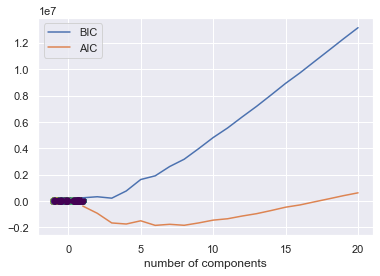

In [8]:
from sklearn.mixture import GaussianMixture

gmModel = GaussianMixture(n_components=8, covariance_type="full").fit(cnngov_samples)
labels = gmModel.predict(cnngov_samples)
plt.scatter(cnngov_samples.values[:, 0], cnngov_samples.values[:, 1], c=labels, s=40, cmap='viridis')

#Giving each components' densities for this sample data
print(gmModel.predict_proba(challenge))


#Giving the Akaike and Bayesian information criteria for this model on the sample data, to help decide the # of components.
#Try to pick # of components that minimizes either of these criteria.
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cnngov_samples)
          for n in n_components]

plt.plot(n_components, [m.bic(cnngov_samples) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cnngov_samples) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('number of components');


# the moment of truth...
print('The most likely clusters for each article.')
challengeGM = gmModel.predict(challenge)
print(challengeGM)

# On a side note, I'm very curious to see if these generated embeddings correspond to anything...
# print(gmModel.sample(5))